In [1]:
import sys

sys.path.append("./../..")

from numba import jit
from numba.types import bool_, int_
import numpy as np
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single
from scipy.optimize import curve_fit
from scipy.stats import moment

from tqdm import tqdm

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import torch

# The Run and Tumble Model

A particle undergoing RnT motion moves in a sequence of runs at constant self-propulsion speed $\omega$ interrupted by sudden changes (tumbles) in its orientation that happen at Poissonian rate $\alpha$

The simulator runs the RnT model for a given number of particles and time steps. The particles are initialized all at $x_0 = 0$ and right facing velocity.
The particles move in 1D space with an harmonic potential $V(x) = \frac{1}{2} k x^2$ acting on them. There are no boundary conditions.

At a rate $\alpha$ the particles change their velocity to the opposite direction.

The simulation is done in the following way:
1. Initialize the particles at $x_0 = 0$ and right facing velocity.
2. Check if a tumble event happens at the current time step.
2. Update the position of the particles according to the current velocity, potential and add a stochastic term to the velocity.

In [158]:
@jit
def RunTumble(param, n_sim, dt=0.01, TotalT=1, alpha=0.5):
    k = param[0]
    omega = param[1]
    D = omega**2 / alpha
    
    total_time_steps = np.int64(TotalT / dt)
    
    x = np.zeros((1, n_sim))
    x_trace = np.zeros((n_sim, total_time_steps))
    
    direction = np.ones((1, n_sim))
    
    for n in range(1, total_time_steps):
        change = np.random.uniform(0, 1, size=(1, n_sim)) < alpha * dt / 2 # Change direction with probability alpha*dt/2
        change = -(change *2 -1) # From boolean to -1 or 1 (false = 1, true = -1)
        direction = change*direction # Change direction if change is true
        x[:] = x[:] + (-k * x[:] + omega * direction) * dt + np.sqrt(2 * D * dt) * np.random.normal(0, 1, size=(1, n_sim))
        x_trace[:, n] = x[:,]
    
    return x_trace

Let us define the parameters of our model and simulation. As this is a highly stochastic model, we will run the simulation for a large number of particles.

In [159]:
ModelParameter = np.array([1, 1]) # [k, omega]
NumberOfParticles = 1000 # Number of particles to simulate
TotalTime = 10 # Total time of simulation
dt = 1e-3 # Time step
alpha = 0.5 # Tumbling rate
t = np.arange(0, TotalTime, dt) # Time vector

Let's simulate a single example particle and visualize its trajectory.

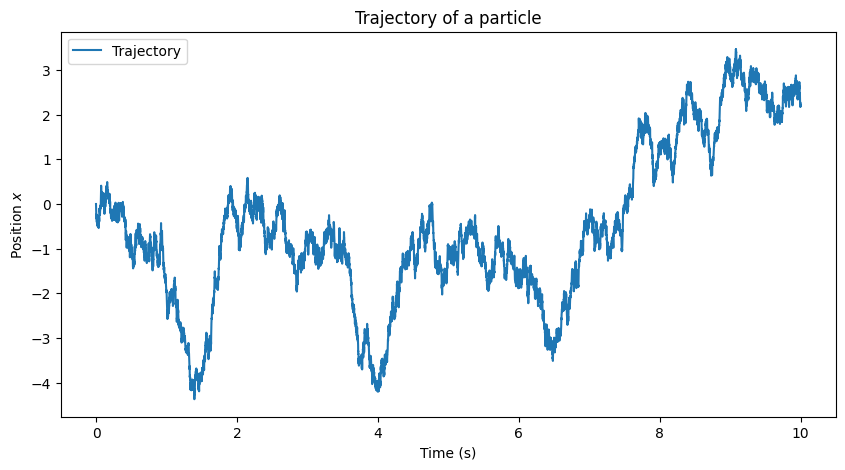

In [160]:
x_trace = RunTumble(ModelParameter, NumberOfParticles, dt, TotalTime, alpha) # Run the model

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, x_trace[0,:], label="Trajectory")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position $x$")
ax.legend()
ax.set_title("Trajectory of a particle");


We can also see the distribution of the trajectories of the particles.

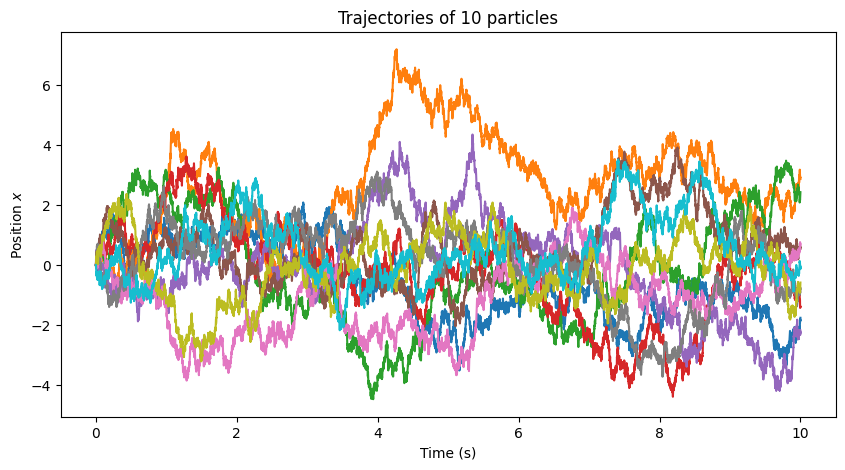

In [161]:
x_trace = RunTumble(ModelParameter, NumberOfParticles, dt, TotalTime, alpha) # Run the model

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in np.arange(0, 10):
    ax.plot(t, x_trace[i,:], label="Trajectory")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position $x$")
ax.set_title("Trajectories of 10 particles");

In [162]:
## Helper Functions

## Cumulative Mean

def CumMean(data):
    return np.cumsum(data, axis=1) / np.arange(1, len(data[0,:]) + 1)

def MeanSecondMoment(data):
    return np.cumsum(data**2, axis=1) / np.arange(1, len(data[0,:]) + 1)

# Theoretical Observables

First moment of the position of a RnT particle:

$$\langle x(t) \rangle = x_0 e^{-kt} + \frac{\omega}{k - \alpha} \left(e^{-\alpha t}- e^{-kt}\right)$$

Second moment of the position of a RnT particle:

$$
\begin{aligned}
\left\langle x^2(t)\right\rangle &= x_0^2 e^{-2 k t}+\frac{D}{k}\left(1-e^{-2 k t}\right)+2 \frac{x_0 w}{k-\alpha}\left(e^{-(k+\alpha) t}-e^{-2 k t}\right) \\
& +2 w^2\left(\frac{\exp (-2 k t)}{2 k(k-\alpha)}+\frac{\exp (-(k+\alpha) t)}{(k+\alpha)(\alpha-k)}+\frac{1}{2 k(k+\alpha)}\right)
\end{aligned}
$$

Then, the mean square displacement at stationarity is
$$
\lim _{t \rightarrow \infty} R^2(t)=x_0^2+\frac{D}{k}+\frac{w^2}{k(k+\alpha)}
$$

In [163]:
## Theorical Observables
### First Moment

def first_moment(k, omega, alpha, t, x0 = 0):
    return x0 * np.exp(-k*t) + (omega / (k - alpha)) * (np.exp(-alpha*t) - np.exp(-k*t))

### Second Moment

def second_moment(k, omega, alpha, t, x0 = 0):
    D = omega**2 / alpha
    
    return  x0**2 * np.exp(-2*k*t) + D/k * (1 - np.exp(-2*k*t)) + 2*x0*omega/(k-alpha) * (np.exp(-(k+alpha)*t) - np.exp(2*k*t)) + 2*omega**2 *(np.exp(-2*k*t/(2*k*(k-alpha))) + np.exp(-(k+alpha)*t)/((k+alpha)*(alpha-k)) + 1/(2*k*(k+alpha)))

def MeanSquareDisplacement(k, omega, alpha, x0 = 0):
    D = omega**2 / alpha
    return x0**2 + D/k + omega**2/(k*(k+alpha))


In [164]:
k = ModelParameter[0]
omega = ModelParameter[1]

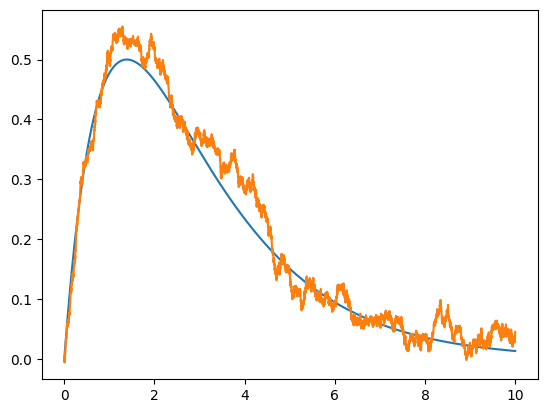

In [165]:
plt.plot(t, first_moment(k, omega, alpha, t))
mm = np.mean(x_trace, axis=0)
plt.plot(t, mm)

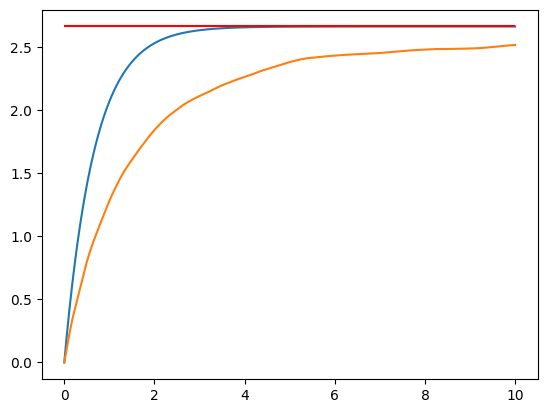

In [167]:
plt.plot(t, second_moment(k, omega, alpha, t))
mm = np.mean(MeanSecondMoment(x_trace),axis = 0)
plt.plot(t, mm)
plt.hlines(MeanSquareDisplacement(k, omega, alpha), 0, TotalTime, color='r');